<a href="https://colab.research.google.com/github/phyml4e/PINNs/blob/main/COMM_PINN/3D_PINN_CZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Model Derivation and Data Generation**

to do
- ---

In [ ]:
pip install sciann -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 15.2 MB/s eta 0:00:00


In [ ]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import sciann as sn
from sciann import Variable, Functional, SciModel
from sciann.constraints import Data
from sciann.utils.math import diff
from numpy import gradient

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.12.0 
Python Version: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0] 



In [ ]:
# Material model 
#def TSL(gs1,gs2,gn,d_i,xid_i,prop):
def TSL(gv, d_i, xid_i, prop):

  ks1 = prop[0]             # Initial stiffness
  ks2 = prop[1]             # Initial stiffness
  kn  = prop[2]             # Initial stiffness
  h1  = prop[3]             # Interface damage hardening parameter 1
  h2  = prop[4]             # Interface damage hardening parameter 2
  y0  = prop[5]             # damage onset
  
  K   = np.array([[ks1, 0, 0], [0, ks2, 0], [0, 0, kn]])
  En  = np.dot(np.dot(gv, K), gv)
  YT = (1 - d_i)*En
  phi = YT - (y0 + h1*(1 - math.exp(-h2*xid_i)))    # Damage criteria

  if phi < 0:              # elastic step
    d   = d_i
    xid = xid_i
    #tngMM = ((1-d)**2)*k0
  else:                    # damage step      
    d   = d_i
    xid = xid_i
    Y   = (1 - d)*En
    rd = np.zeros([2, 1])
    rd[0,0] = d - d_i - (xid - xid_i)
    rd[1,0] = Y - (y0 + h1*(1 - math.exp(-h2*xid)))

    while np.linalg.norm(rd) > 10**(-10):

      Kd      = np.zeros([2,2])
      Kd[0,0] = 1
      Kd[0,1] = -1
      Kd[1,0] = -En
      Kd[1,1] = -h1*h2*math.exp(-h2*xid)       

      Dsol    = np.linalg.lstsq(-Kd, rd)[0]
      d       = d + Dsol[0,0]                         
      xid     = xid + Dsol[1,0]                      
      Y       = (1 - d)*En

      rd[0,0] = d - d_i - (xid - xid_i)                   # final evol eq
      rd[1,0] = Y - (y0 + h1*(1 - math.exp(-h2*xid)))     # final yeild fn

    if d < d_i:
      d = d_i
      xid = xid_i

  tra = ((1-d)**2)*np.dot(K, np.transpose(gv))
  ene = ((1-d)**2)*0.5*En + (h1*(xid + (math.exp(-h2*xid)-1)/h2))
  #tngMM = k0*(1 - k0/(k0 + h1*h2*np.exp(-h2*xid) ))
  
  return tra,d,xid,ene

In [ ]:
# Material Parameters
ks1  = 0.5         # Initial stiffness
ks2  = 2.0         # Initial stiffness
kn   = 5.0         # Initial stiffness
h1   = 2.0         # Interface damage hardening parameter 1
h2   = 1.0         # Interface damage hardening parameter 2
y0   = 0.1         # Damage onset
prop = [ks1, ks2, kn, h1, h2, y0]



In [ ]:
# Generation of collocation points in 3D
       
step = 0.05  
endg = 0.5
n    = 0

gs1  = np.array(np.arange(0.0, endg+step, step))
gs2  = np.array(np.arange(0.0, endg+step, step))
gn   = np.array(np.arange(0.0, endg+step, step))
pd   = np.array(np.arange(0.0, 0.5+step, step))
px   = np.array(np.arange(0.0, 0.5+step, step))

#print(len(pg))
#print(pg)

row = len(gs1)*len(gs2)*len(gn)*len(pd)*len(px)
INe = np.zeros((row,5))

print(len(INe))
#print(IN)

for i in range(len(gs1)):                           
    for j in range(len(gs2)):
        for k in range(len(gn)):
            for p in range(len(pd)):
                for q in range(len(px)):
                    INe[n,0] = gs1[i]
                    INe[n,1] = gs2[j]
                    INe[n,2] = gn[k]
                    INe[n,3] = pd[p]
                    if px[q] == pd[p]: 
                       INe[n,4] = px[q]
                       n += 1
            
IN  = np.zeros((n,5))
n = 0     
for i in range(len(gs1)):                           
    for j in range(len(gs2)):
        for k in range(len(gn)):
            for p in range(len(pd)):
                for q in range(len(px)):
                    IN[n,0] = gs1[i]
                    IN[n,1] = gs2[j]
                    IN[n,2] = gn[k]
                    IN[n,3] = pd[p]
                    if px[q] == pd[p]: 
                       IN[n,4] = px[q]
                       n += 1

print(len(IN[:,0]))
print(n)


161051
14641
14641


# **Training**

In [ ]:
#Designinh the network
dtype     = 'float32' 
n_of_n    = 5*[100]        # Number of neurons (layers*[neurons])  4*[10]   3*[5]  20*[20]  ??? not so low
act       = 'Relu'        # Activation function  # "tanh", "softplus", "Relu", "sigmoid", "softmax" 
Epochs    = 2000           # Number of epochs  
batch     = 50            # Batch size  ?? 400 
LR        = 0.0001           # Learning rate 0.01  
Optimizer ='adam'            # such as 'scipy-l-BFGS-B' , 'SGD'

x1 = sn.Variable('x1', dtype=dtype)
x2 = sn.Variable('x2', dtype=dtype)
x3 = sn.Variable('x3', dtype=dtype)
x4 = sn.Variable('x4', dtype=dtype)
x5 = sn.Variable('x5', dtype=dtype)

y2 = sn.Functional('y2',[x1, x2, x3, x4, x5], n_of_n, act)
y3 = sn.Functional('y3',[x1, x2, x3, x4, x5], n_of_n, act)

#dy2dx1 = diff(y2,x1)

#Splitting the data into inputs and outputs
x1_1 = IN[:,0]        # Gap    
x2_1 = IN[:,1]        # Gap
x3_1 = IN[:,2]        # Gap
x4_1 = IN[:,3]        # Damage variable @ n
x5_1 = IN[:,4]        # Damage hardening variable @ n


In [ ]:
#Defining the physical constraints
kpt = 10.0
kpu = 100.0                   #penalty term
kpe = 1.0                   #penalty term
kpy = 1.0                   #penalty term
kpd = 1.0                   #penalty term 
kpx = 100.0                   #penalty term 

##############
gv  = np.array([x1, x2, x3])
K   = np.array([[ks1, 0, 0], [0, ks2, 0], [0, 0, kn]])
En  = np.dot(np.dot(gv, K), gv)

phi_o = (1 - x4)*En - (y0 + h1*(1 - sn.exp(-h2*x5)))    # Damage criteria
phi   = (1 - y2)*En - (y0 + h1*(1 - sn.exp(-h2*y3)))
##############

#physical constraints 
const1 = kpt*(y2-x4)*sn.relu(-phi_o)                # unload d
const2 = kpu*(y3-x5)*sn.relu(-phi_o)                # unload xid   
const3 = kpe*( y2-x4 - (y3-x5) )*sn.relu(phi_o)     # evolution eq.  d - d_i - (xid - xid_i)
const4 = kpy*phi*sn.relu(phi_o)                     # yield function
const5 = kpd*(1.0)*sn.relu(phi)                     # growing d      *(x2-y2)
const6 = kpx*(1.0)*sn.relu(x5-y3)                   # growing xid    *(x3-y3)
  

In [ ]:
#Defining the model
model = sn.SciModel([x1, x2, x3, x4, x5],[const1, const2, const3, const4, const5, const6], loss_func="mse", optimizer = Optimizer)

#Defining the inputs and outputs
x_data = [x1_1, x2_1, x3_1, x4_1, x5_1]

y_data = ['zeros', 'zeros', 'zeros', 'zeros', 'zeros', 'zeros']


In [ ]:
ADAPTIVE_WEIGHTS = {'method': 'GN', 'freq': 100, 'use_score': True, 'alpha': 1.0}

In [ ]:
#Fitting the model
history1 = model.train(x_data, y_data, learning_rate=LR, epochs=Epochs, batch_size=batch,verbose=-1)#, **{'adaptive_weights': ADAPTIVE_WEIGHTS})
#history1 = model.train(x_data, y_data, learning_rate=LR, epochs=Epochs, batch_size=batch,verbose=-1, **{'adaptive_weights': ADAPTIVE_WEIGHTS})#

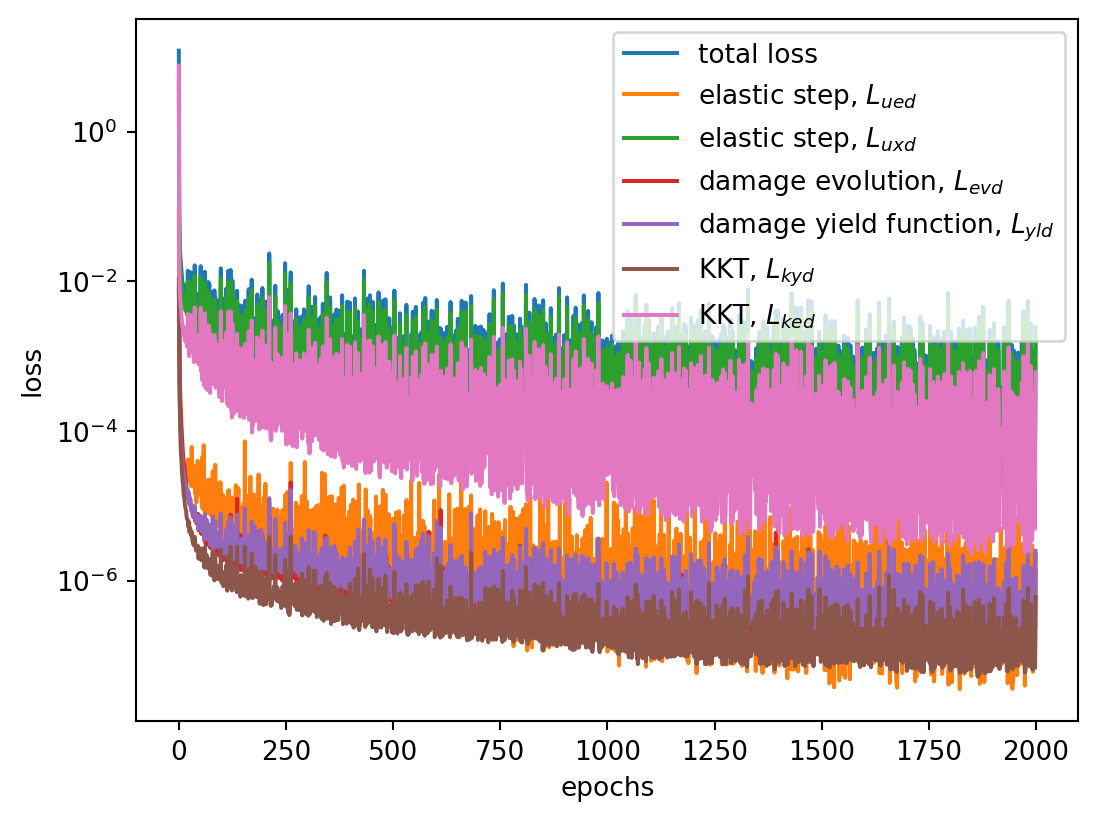

In [ ]:
loss_name = ['total loss','elastic step, $L_{ued}$','elastic step, $L_{uxd}$', 'damage evolution, $L_{evd}$','damage yield function, $L_{yld}$', 'KKT, $L_{kyd}$', 'KKT, $L_{ked}$']

#fig = plt.figure(figsize=(12, 7))
fig = plt.figure(dpi = 190)
itter = 0 
for word, loss in history1.history.items():
        if word.endswith("loss"):
            plt.semilogy(np.array(loss), label=loss_name[itter])
            itter+=1
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('loss_dmg.pdf')

# **POST PROCESS**

In [ ]:
step_size = 0.05
num_steps = int(1 / step_size) + 1
Gap = np.zeros((num_steps,3))
Tra = np.zeros((num_steps,3))
Dmg = np.zeros((num_steps))
Xid = np.zeros((num_steps))
Ene = np.zeros((num_steps))

for i in range(num_steps):
    t = i * step_size
    #Gap[i,:] = np.array([0*t**3, 0*t**2, 1.5*t**1])
    Gap[i,:] = np.array([0.5*abs(np.sin(3.1415*2*t)), 0.5*abs(np.cos(3.1415*2*t)), 0.5*t**2])
    #Gap[i,:] = np.array([0.5*t**3, 0.5*t**2, 0.5*abs(t*np.sin(3.1415*3*t))])
    ##Gap[i,:] = np.array([0.2*t**3, 0.4*abs(np.sin(3.1415*1*t)), 0.5*abs(t*np.sin(3.1415*2*t))])


In [ ]:
for i in range(num_steps-1):
    Tra[i+1,:], Dmg[i+1], Xid[i+1], Ene[i+1] = TSL(Gap[i+1,:], Dmg[i], Xid[i], prop)

x1_NN = Gap[:,0]
x1_NN = x1_NN.reshape(-1,1)
x2_NN = Gap[:,1]
x2_NN = x2_NN.reshape(-1,1)
x3_NN = Gap[:,2]
x3_NN = x3_NN.reshape(-1,1)
x4_NN = np.zeros_like(x1_NN)
x5_NN = np.zeros_like(x1_NN)
trc_N = np.zeros_like(Gap)
#eneNN = np.zeros_like((num_steps))

for k in range(len(Gap)-1):
    x4_NN[k+1]   = y2.eval([ x1_NN[k+1], x2_NN[k+1], x3_NN[k+1], x4_NN[k], x5_NN[k] ])
    x5_NN[k+1]   = y3.eval([ x1_NN[k+1], x2_NN[k+1], x3_NN[k+1], x4_NN[k], x5_NN[k] ])
    trc_N[k+1,0] = (1 - x4_NN[k+1])**2 * ks1 * x1_NN[k+1]
    trc_N[k+1,1] = (1 - x4_NN[k+1])**2 * ks2 * x2_NN[k+1]
    trc_N[k+1,2] = (1 - x4_NN[k+1])**2 * kn  * x3_NN[k+1]
    #eneNN[k+1]   = 0.5*(x1_NN[k+1]**2)*k0*(1.0 - x2_NN[k+1])**2 + h1*(x3_NN[k+1] + (math.exp(-h2 * x3_NN[k+1])-1)/h2)
    

<ipython-input-3-02c76472baa5>:37: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Dsol    = np.linalg.lstsq(-Kd, rd)[0]


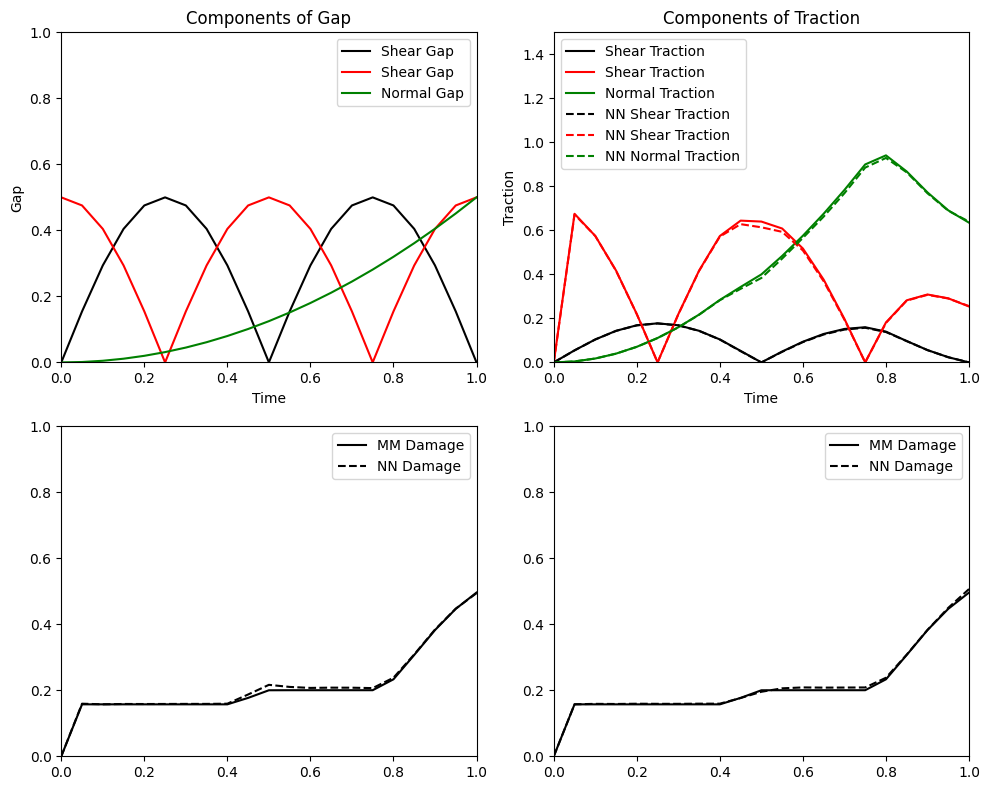

<Figure size 640x480 with 0 Axes>

In [ ]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot Ga in the first subplot
axs[0, 0].plot(np.linspace(0, 1, num_steps), x1_NN, 'k-', label='Shear Gap')
axs[0, 0].plot(np.linspace(0, 1, num_steps), x2_NN, 'r-', label='Shear Gap')
axs[0, 0].plot(np.linspace(0, 1, num_steps), x3_NN, 'g-', label='Normal Gap')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Gap')
axs[0, 0].set_title('Components of Gap')
axs[0, 0].legend()
axs[0, 0].set_xlim(0, 1.0)
axs[0, 0].set_ylim(0, 1.0)

# Plot Tr in the second subplot
axs[0, 1].plot(np.linspace(0, 1, num_steps), Tra[:, 0], 'k-', label='Shear Traction')
axs[0, 1].plot(np.linspace(0, 1, num_steps), Tra[:, 1], 'r-', label='Shear Traction')
axs[0, 1].plot(np.linspace(0, 1, num_steps), Tra[:, 2], 'g-', label='Normal Traction')
axs[0, 1].plot(np.linspace(0, 1, num_steps), trc_N[:, 0], 'k--', label='NN Shear Traction')
axs[0, 1].plot(np.linspace(0, 1, num_steps), trc_N[:, 1], 'r--', label='NN Shear Traction')
axs[0, 1].plot(np.linspace(0, 1, num_steps), trc_N[:, 2], 'g--', label='NN Normal Traction')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Traction')
axs[0, 1].set_title('Components of Traction')
axs[0, 1].legend()
axs[0, 1].set_xlim(0, 1.0)
axs[0, 1].set_ylim(0, 1.5)

# Plot damage
axs[1, 0].plot(np.linspace(0, 1, num_steps), Dmg, 'k-', label='MM Damage')
axs[1, 0].plot(np.linspace(0, 1, num_steps), x4_NN, 'k--', label='NN Damage')
axs[1, 0].legend()
axs[1, 0].set_xlim(0, 1.0)
axs[1, 0].set_ylim(0, 1.0)

# Plot damage hardening
axs[1, 1].plot(np.linspace(0, 1, num_steps), Xid, 'k-', label='MM Damage')
axs[1, 1].plot(np.linspace(0, 1, num_steps), x5_NN, 'k--', label='NN Damage')
axs[1, 1].legend()
axs[1, 1].set_xlim(0, 1.0)
axs[1, 1].set_ylim(0, 1.0)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

plt.savefig('reponse.pdf')


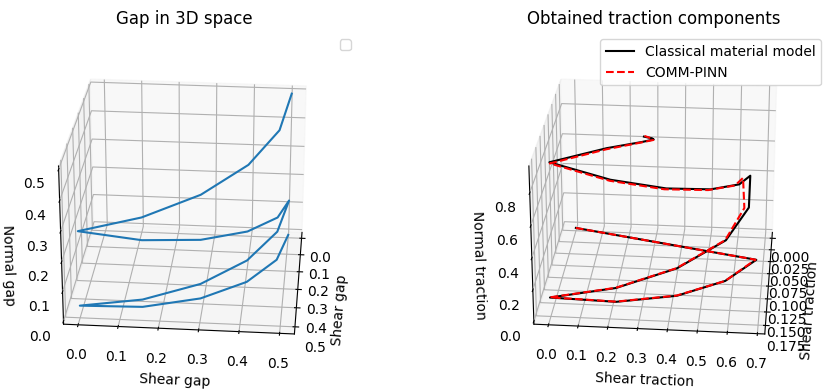

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create a figure with two 3D subplots side by side
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# Plot Ga in the first subplot
ax1.plot(Gap[:, 0], Gap[:, 1], Gap[:, 2])
ax1.set_xlabel('Shear gap')
ax1.set_ylabel('Shear gap')
ax1.set_zlabel('Normal gap')
ax1.set_title('Gap in 3D space')
ax1.legend()


# Plot Ga in the second subplot
ax2.plot(Tra[:, 0], Tra[:, 1], Tra[:, 2], 'k-', label='Classical material model')
ax2.plot(trc_N[:, 0], trc_N[:, 1], trc_N[:, 2], 'r--', label='COMM-PINN')
ax2.set_xlabel('Shear traction')
ax2.set_ylabel('Shear traction')
ax2.set_zlabel('Normal traction')
ax2.set_title('Obtained traction components')
ax2.legend()


# Adjust the spacing between subplots
fig.tight_layout()

ax1.view_init(elev=25, azim=5)
ax2.view_init(elev=25, azim=5)

# Show the plot
plt.show()

plt.savefig('3D.pdf')
